In [129]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [130]:
# grab / parse data

In [131]:
directory = "midi/Piano"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
for i, file in enumerate(os.listdir(directory)):
    midi_part = converter.parse(os.path.join(directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        notes_to_parse = notes_to_parse.makeMeasures()
        for meas in notes_to_parse.measures(0, None):
            if isinstance(meas, stream.Measure):
                meas = meas.chordify()
                notes_meas_tab = []
                durations_meas_tab = []
                for elem in meas:    
                    if isinstance(elem, note.Note):
                        notes_meas_tab.append([str(elem.pitch)])
                        durations_meas_tab.append(elem.quarterLength)
                    elif isinstance(elem, chord.Chord):
                        notes_meas_tab.append([str(n.nameWithOctave) for n in elem.pitches])
                        durations_meas_tab.append(elem.quarterLength)
                    elif isinstance(elem, note.Rest):
                        notes_meas_tab.append([elem.name])
                        durations_meas_tab.append(elem.quarterLength)
                notes[track].append(notes_meas_tab)
                durations[track].append(durations_meas_tab)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        np_notes[track] += elem
np_notes = [np.array(np_notes[track]) for track in tracks]
np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
np_durations = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in durations[track]:
        np_durations[track] += elem
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(np.array(np_durations[track]).flatten()))

for track, _ in enumerate(tracks):
    print("%s Measures, notes_Vocab : %s ; durations_Vocab : %s" % (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song br_im2_format0.mid Loaded
Song br_im5_format0.mid Loaded
Song br_im6_format0.mid Loaded
Song br_rhap_format0.mid Loaded
Song chpn_op7_1_format0.mid Loaded
Song chpn_op7_2_format0.mid Loaded
Song chp_op18_format0.mid Loaded
Song chp_op31_format0.mid Loaded
Song Etude op10 n01.mid Loaded
Song Etude op10 n02.mid Loaded
Song Etude op10 n10.mid Loaded
Song jsb2pin1.mid Loaded
Song jsb2pin4.mid Loaded
Song jsb2pin8.mid Loaded
DONE LOADING SONGS
1283 Measures, notes_Vocab : 3520 ; durations_Vocab : 73
[['A1', 'A1,A2', 'A1,A2,A4', 'A1,A2,A4,C5,A5', 'A1,A2,A5,D6,F6', 'A1,A2,B-5', 'A1,A2,B5', 'A1,A2,C#4', 'A1,A2,C#4,A4', 'A1,A2,C#7', 'A1,A2,C4,G#4,B4', 'A1,A2,C5', 'A1,A2,C5,E5,A5', 'A1,A2,C6', 'A1,A2,C6,E6,A6', 'A1,A2,D5,F5,A5', 'A1,A2,D6', 'A1,A2,E-6', 'A1,A2,E3,C#4,E4', 'A1,A2,E4', 'A1,A2,E5,A5,C#6', 'A1,A2,E6', 'A1,A2,F#5', 'A1,A2,F#6', 'A1,A2,F4', 'A1,A2,F5,A5,C#6', 'A1,A2,G#5', 'A1,A2,G#6', 'A1,A2,G4', 'A1,A2,G5', 'A1,A2,G6', 'A1,A3', 'A1,A3,C#4,A4', 'A1,A3,F#4', 'A1,A4', 'A1,A4,A5', '

In [132]:
maxLen = 0
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in notes[track])
    if currMax > maxLen:
        maxLen = currMax
for track, _ in enumerate(tracks):
    currMax = max(len(elem) for elem in durations[track])
    if currMax > maxLen:
        maxLen = currMax
        
print(maxLen)

31


In [133]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]

for track, _ in enumerate(tracks):
    for mes in notes[track]:
        cat_tab = []
        for elem in mes:
            int_note = notes_vocab[track].index(",".join(elem))
            cat = np.zeros((len(notes_vocab[track])))
            cat[int_note] = 1
            cat_tab.append(cat)
        cat_notes[track].append(cat_tab)
    cat_notes[track] = pad_sequences(cat_notes[track], maxlen=maxLen)
    for mes in durations[track]:
        cat_tab = []
        for elem in mes:
            int_duration = durations_vocab[track].index(elem)
            cat = np.zeros((len(durations_vocab[track])))
            cat[int_duration] = 1
            cat_tab.append(cat)
        cat_durations[track].append(cat_tab)
    cat_durations[track] = pad_sequences(cat_durations[track], maxlen=maxLen)
# merge
x = [cat_notes, cat_durations]

In [134]:
# Build generator

In [135]:
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                X_note[track].append(self.x[0][track][idx + i])
                X_duration[track].append(self.x[1][track][idx + i])
                Y_note[track].append(self.x[0][track][idx + i + 1])
                Y_duration[track].append(self.x[1][track][idx + i + 1])
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
        return res
data_gen = dataGenerator(x, batch_size)

In [136]:
data_gen[0][0][0].shape

(32, 31, 3520)

In [137]:
# Build Model

In [138]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(maxLen, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Masking(mask_value=0.0)(in_note)
    x1 = LSTM(64, return_sequences=True)(x1)
    x1 = LSTM(32, return_sequences=True)(x1)
    tracks_list.append(x1)
    in_duration = Input(shape=(maxLen, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Masking(mask_value=0.0)(in_duration)
    x2 = LSTM(64, return_sequences=True)(x2)
    x2 = LSTM(32, return_sequences=True)(x2)
    tracks_list.append(x2)

concat = Concatenate()(tracks_list)
shared = TimeDistributed(Dense(64, activation='relu'))(concat)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 31, 3520)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 31, 73)       0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 31, 3520)     0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 31, 73)       0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [139]:
#save best model if model improved
model_name = "Piano_measured.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [140]:
h = model.fit_generator(data_gen, epochs = 100)

Epoch 1/100
39/39 [==============================] - 53s 1s/step - loss: 9.5371 - dense_2_loss: 6.7476 - dense_3_loss: 2.7896 - dense_2_acc: 0.0289 - dense_3_acc: 0.2150
Epoch 2/100
39/39 [==============================] - 17s 438ms/step - loss: 7.0067 - dense_2_loss: 5.1410 - dense_3_loss: 1.8658 - dense_2_acc: 0.0404 - dense_3_acc: 0.2304
Epoch 3/100
39/39 [==============================] - 16s 411ms/step - loss: 6.4836 - dense_2_loss: 4.7892 - dense_3_loss: 1.6944 - dense_2_acc: 0.0472 - dense_3_acc: 0.2640
Epoch 4/100
39/39 [==============================] - 16s 400ms/step - loss: 5.9563 - dense_2_loss: 4.4826 - dense_3_loss: 1.4737 - dense_2_acc: 0.0533 - dense_3_acc: 0.3382
Epoch 5/100
39/39 [==============================] - 17s 426ms/step - loss: 5.6345 - dense_2_loss: 4.2498 - dense_3_loss: 1.3847 - dense_2_acc: 0.0548 - dense_3_acc: 0.3671
Epoch 6/100
39/39 [==============================] - 15s 386ms/step - loss: 5.4457 - dense_2_loss: 4.0911 - dense_3_loss: 1.3546 - dense_2

39/39 [==============================] - 16s 414ms/step - loss: 0.6292 - dense_2_loss: 0.3866 - dense_3_loss: 0.2426 - dense_2_acc: 0.7922 - dense_3_acc: 0.7819
Epoch 49/100
39/39 [==============================] - 16s 420ms/step - loss: 0.6215 - dense_2_loss: 0.3807 - dense_3_loss: 0.2408 - dense_2_acc: 0.7888 - dense_3_acc: 0.7828
Epoch 50/100
39/39 [==============================] - 16s 404ms/step - loss: 0.5730 - dense_2_loss: 0.3493 - dense_3_loss: 0.2237 - dense_2_acc: 0.8038 - dense_3_acc: 0.7918
Epoch 51/100
39/39 [==============================] - 16s 412ms/step - loss: 0.5690 - dense_2_loss: 0.3462 - dense_3_loss: 0.2228 - dense_2_acc: 0.8012 - dense_3_acc: 0.7877
Epoch 52/100
39/39 [==============================] - 16s 421ms/step - loss: 0.5458 - dense_2_loss: 0.3327 - dense_3_loss: 0.2131 - dense_2_acc: 0.7997 - dense_3_acc: 0.7939
Epoch 53/100
39/39 [==============================] - 16s 398ms/step - loss: 0.5424 - dense_2_loss: 0.3258 - dense_3_loss: 0.2166 - dense_2_acc

39/39 [==============================] - 17s 432ms/step - loss: 0.2115 - dense_2_loss: 0.1266 - dense_3_loss: 0.0849 - dense_2_acc: 0.8303 - dense_3_acc: 0.8383
Epoch 96/100
39/39 [==============================] - 17s 431ms/step - loss: 0.2010 - dense_2_loss: 0.1192 - dense_3_loss: 0.0818 - dense_2_acc: 0.8337 - dense_3_acc: 0.8398
Epoch 97/100
39/39 [==============================] - 17s 435ms/step - loss: 0.2098 - dense_2_loss: 0.1226 - dense_3_loss: 0.0871 - dense_2_acc: 0.8328 - dense_3_acc: 0.8364
Epoch 98/100
39/39 [==============================] - 16s 421ms/step - loss: 0.3007 - dense_2_loss: 0.1738 - dense_3_loss: 0.1269 - dense_2_acc: 0.8108 - dense_3_acc: 0.8217
Epoch 99/100
39/39 [==============================] - 17s 435ms/step - loss: 0.1861 - dense_2_loss: 0.1098 - dense_3_loss: 0.0763 - dense_2_acc: 0.8373 - dense_3_acc: 0.8420
Epoch 100/100
39/39 [==============================] - 17s 439ms/step - loss: 0.2114 - dense_2_loss: 0.1291 - dense_3_loss: 0.0823 - dense_2_ac

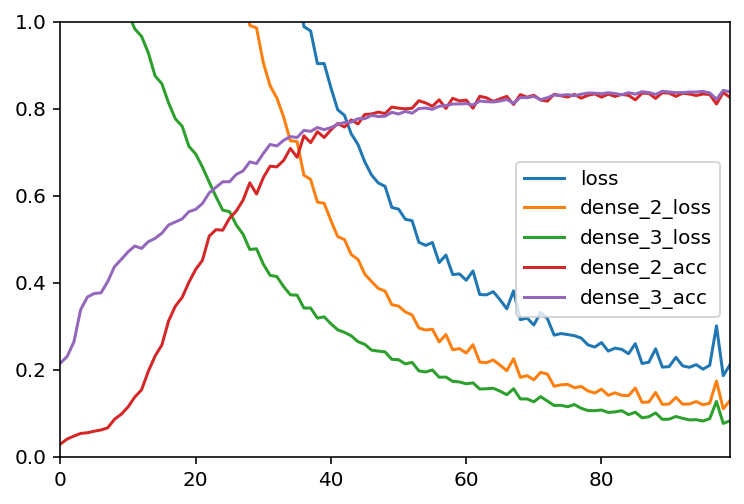

In [141]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [142]:
# Load / save

In [143]:
model_name = "Piano_measured.h5"
model.save(os.path.join("weight_save", model_name))
#model = load_model(os.path.join("weight_save", model_name))

In [144]:
# Test

In [155]:
# Build seed
idx = 627
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(maxLen):
        if 1 in x_test[2*track][i]:
            str_note = notes_vocab[track][np.argmax(x_test[2*track][i])]
            duration = durations_vocab[track][np.argmax(x_test[2*track+1][i])]
            if len(str_note.split(",")) > 1:
                _chord = chord.Chord(str_note.split(","))
                _chord.quarterLength = duration
                x_test_stream[track].append(_chord)
            else:
                if str_note != "rest":
                    _note = note.Note(str_note)
                    _note.quarterLength = duration
                    x_test_stream[track].append(_note)
                else:
                    _rest = note.Rest()
                    _rest.quarterLength = duration
                    x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [160]:
# make prediction from seed
x = x_test
pred = [[] for track in tracks]
preds = [[] for track in tracks]

for track, _ in enumerate(tracks):
    for mes in range(2):        
        pred[track] = model.predict([np.array([x[i]]) for i in range(len(x))])
        x = [pred[track][i][0] for i in range(len(pred[track]))]
        preds[track].append(pred[track])


In [161]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for j in range(len(preds[track])):
        for i in range(maxLen):
            if 1 in x_test[2*track][i]:
                str_note = notes_vocab[track][np.argmax(preds[track][j][0][0][i])]
                duration = durations_vocab[track][np.argmax(preds[track][j][1][0][i])]
                if len(str_note.split(",")) > 1:
                    _chord = chord.Chord(str_note.split(","))
                    _chord.quarterLength = duration
                    y_test_stream[track].append(_chord)
                else:
                    if str_note != "rest":
                        _note = note.Note(str_note)
                        _note.quarterLength = duration
                        y_test_stream[track].append(_note)
                    else:
                        _rest = note.Rest()
                        _rest.quarterLength = duration
                        y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [162]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.makeMeasures()#.show('musicxml')
x_full_score.chordify()
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [163]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.makeMeasures()#.show('musicxml')
y_full_score.chordify()
y_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()